# 0. Intro

### Dataset

Project Sentiment Analysis bertujuan untuk mengembangkan sistem cerdas berbasis teknologi AI untuk mengklasifikasi sentiment pada twitter dengan metode text analysis. Sistem ini akan membantu memperoleh **kecenderungan sentimen opini positif, negatif atau netral** dari pengguna di platform tersebut.

Dataset yang digunakan adalah kumpulan tweet dari pengguna twitter saat pelaksanaan **Pilpres 2019**. Dataset tersebut  didapat melalui proses web scraping. Data terdiri dari 1815 tweet yanng memuat tiga kategori sentimen: positif, netral, dan negatif.

### Alur Pelaksanaan

Eksperimen dilakukan dengan menggunakan berbagai ragam teknik preprocessing dan vectorization. Selain itu juga menggunakan **menguji algoritma Random Forest dan LSTM (ditambah hyperparameter tuning untuk model optimization)**.

Setelah itu dilakukan model evaluation dan penarikan kesimpulan untuk memilih algoritma terbaik.

# 1. Data Loading

In [141]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)

In [2]:
tweets = pd.read_csv('./dataset/tweet.csv', index_col=0)

# 2. EDA (before text cleaning)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 42.5+ KB


In [5]:
tweets.shape

(1815, 2)

In [6]:
tweets.isnull().sum()

sentimen    0
tweet       0
dtype: int64

In [7]:
tweets.head()

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


In [8]:
tweets.describe()

,sentimen,tweet
count,1815,1815
unique,3,1815
top,positif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
freq,612,1


## 2.1. Distribution of Sentiment

In [9]:
tweets.sentimen.value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

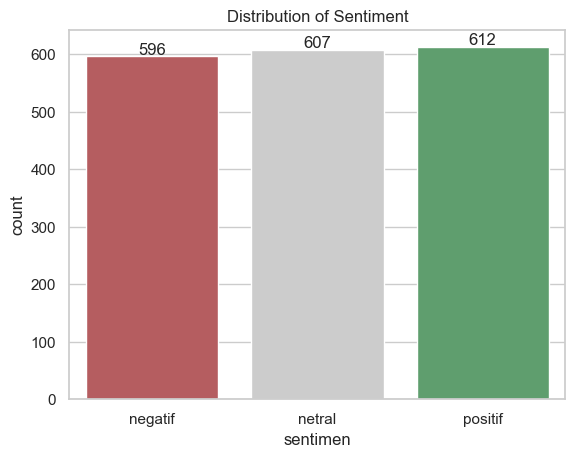

In [10]:
color_palette = {'negatif': 'r', 'netral': '#CCCCCC', 'positif': 'g'}

ax = sns.countplot(data=tweets, x='sentimen', palette=color_palette)
for p in ax.patches:
    ax.annotate(format(p.get_height(),'.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Sentiment')
plt.show()

## 2.2. Number word string

In [11]:
tweets['num_words'] = tweets['tweet'].apply(lambda x:len(str(x).split())) 

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

### 2.2.1. All Sentiment

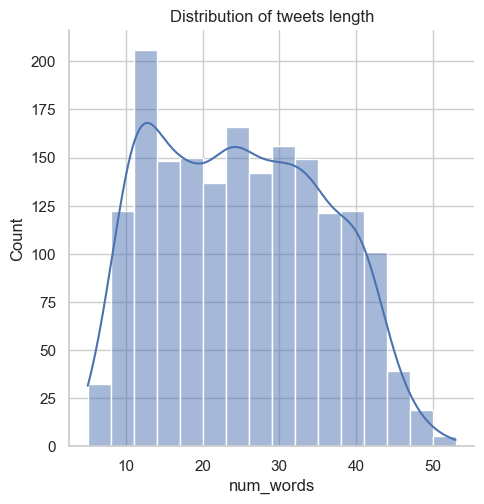

In [12]:
sns.displot(tweets['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.2. negatif sentiment

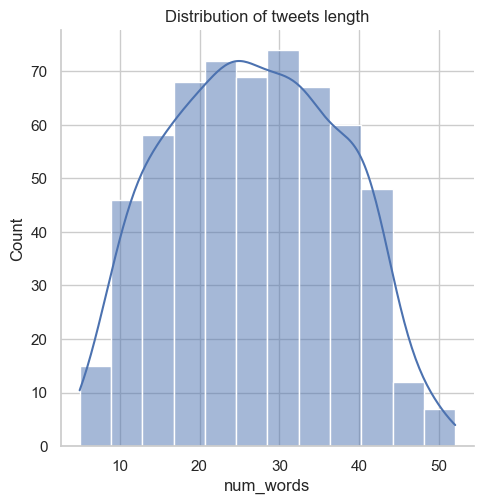

In [13]:
sns.displot(tweets_negatif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.3. netral sentiment

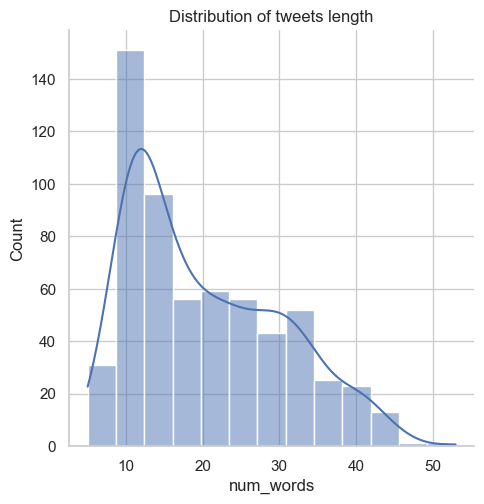

In [14]:
sns.displot(tweets_netral['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 2.2.4. positif sentiment

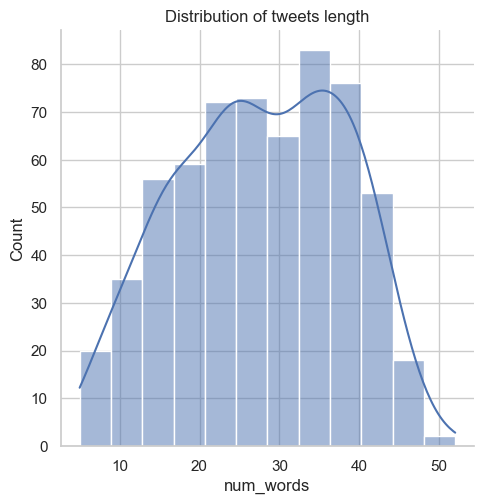

In [15]:
sns.displot(tweets_positif['num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

# 3. Text Preprocessing

0. Remove url and punctuation
1. Slang words to standard words conversion
2. Tokenization
3. Stemming & Lemmatization
4. Stop words removal
5. Word embedding

In [16]:
import re
import string

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### create list stopword

In [17]:
class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
    def get_stop_words(self):
        
        add_sw = ['ga', 'gak', 'yg', 'pak','bapak','ibu','bu','akan', 'utk', 'di', 'untuk', 'itu','selain itu'
                 ,"ud","udah","sdh","sudah","kalau","klo","sy","aing","saia","gue","awak","aq","gua","gw","ak","aku","saya","banget","blibli","tokopedia","shopee","bukalapak","lazada","jdid","zalora","elevenia","sudah","bhinneka","gk","yg","ga","gak","nggak","saja","aja","aj","ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai"
                ,"berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui"
            ,"diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah"
            ,"jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui"
            ,"melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang","anjing","anjiang","anjir","anjay","anying","asu","asoe","babi","bajingan","banci","bangsat","bego","bengak","berak","bokong","bodoh","bongak","edan","fak","fuck","fakboi","bitch","fap","gigolo","goblok","gila","gilo","jablay","jalang","jancuk","jancok","kampret","kafir","kontol","kentot","dancok","kunyuk","kufar","kimak","homo","maho","memek","monyet","ngentot","pantat","pantak","pantek","pecun","pelakor","ngehe","pelacur","perek","peler","pepek","pukimak","setan","syaithon","saiton","sial","sialan","sinting","sintiang","silit","sontoloyo","tai","telek","tolol","lonte","entut","gimana","widihh","nya","gabisa","nambah","kontoll","ih","sih","selesai","banget","si","knapa","bngt","kamu","an","tanggal","dizalora","in","an","ini","emang","sngt","many","to","thank","you","ko","tumben","lho","segitu","kalau","doang","ayo","doank","rbuan","woi","parahhhh","trus","woy","emg","gausah","udh","gadak","huhh","akh","nanti","belum","cuiiihhh","bangt","selamat","begitu","bhineka","situ","loh","deh","mah","yaa","tapi","the","karena","padabal","ttep","sopi","ealah","mas","kampreeeeet","busetttt","tahi","ah","sich","tokped","lzd","gada","gatau","udh","ttep","ehhh","bosss","wkekwk","bajing","laknat","asuuu","ku","woiii","gueeee","njerr","waduhhhh","ma","dunk","dunk","untuk","dll","brupa","sangatx","niih","bos","eh","smua","gni","bye","ajah","gilee","luu","ndro","dg","kga","min","sm","haisshhh","piye","iki","skali","hehehe","ms","juga","fff","mamam","inibsangat","andri","yopiyanto","broo","donk","tes","si","ter","dech","wow","oh","toped","dahhhh","grab","ijo","oren","ovo","gopay","kredivo","sok","david","gaes","dr","ovonya","bbrp","gmna","bbrpa","and","uah","uhahhhhhh","topeeed","ngak","kamu","anj","nge","lah","linkaja","gosend","sicepat","jne","yah","goto","gofood","goride","prakerja","haduhhhh","pediya","kakak","hhe","bro","bismillah","fuulll","goof","assalamualaikum","atsu","pea","you","agan","semenjak","gojek","lagiii","lagi","bts","kkzara","cog","aaaaa","sich","cih","ciyy","padahal","ad","adlh","ahaha","aj","ak","akika","akkoh","akuwh","alow","anjrit","ap2","apasih","aps","aq","aqueh","q","asem","ato","awak","bakalan","bangedh","bcanda","beud","bg","bgmn","bgt","bkl","bknnya","blum","boljug","boyeh","bs","bt","btw","bwt","byk","can","thanks","d","dah","dapet","de","dek","deyh","dgn","disono","dkk","dlu","dngn","dongs","dpt","dri","drmn","drtd","dst","duh","egp","eke","ane","ente","elu","emangnya","emng","endak","enggak","gaada","gag","gaje","gpp","gan","gbs","geje","ghiy","gimana","githu","gj","gn","gt","gpny","gr","gtau","guoblok","ha","haha","hallow","hehe","helo","he","halo","hey","hai","hny","hrus","imho","iye","ja","jadiin","jdi","jga","jir","k","kagak","kalo","kamuwh","karna","katrok","kayanya","kdu","kepengen","kepingin","kl","klianz","klw","km","knp","kpn","kt","kyk","leh","lgi","lgsg","liat","low","lum","maneh","mao","mw","n","napa","nda","ne","ngapah","ngga","ngmng","nie","nih","niyh","np","ogah","pd","pi","pisan","qmu","ruz","saia","samsek","siech","sj","spt","sgt","shg","scr","sbh","sbnrny","sdgkn","td","thankz","tks","ttg","tuch","tuh","u","urang","yawdah","yasudah","adlah","ajj","akko","akyu","ama","aqu","atuh","ayok","bet","beut","bgd","brur","bapak","ibu","bokap","nyokap","cama","ceu","teh","coz","cpa","guys","kaka","kamuh","kamyu","kau","khan","kk","klian","koq","ky","krn","kykny","lu","lw","maaciw","makasih","mba","mas","nyok","qmo","qt","spy","sy","thanks","thx","tp","tq","trims","mz","alfamart","cm","buruk","lambat","jelek","bagus","ok","oke","kecewa","mantap","manfaat","gblk","ni","keren","bagus","ajg","iya","tidak","muas","puas","goblog","tdk","dancuk","huff","lumayan","mayan","y","eek","belum","blm","nyesel","bahagia","senang","seneng","mantul","good","top","suka","not","bad","kak","okey","gitu","coba","sip","nice","job","thanks","terima kasih","moga","lasada","jd","id","parah","for","sumpah","best","bli","payah","blibi","blipay","gg","love","amazing","mantab","terimakasih","cakep","very","bgs","jos","is","euy","gandos","of","waw","biar","buka","lapak","terima","kasih","alhamdulillah","pokok","shoope","shoppe","shope"
                 ]
        
        with open('stopwords/20190327_stopword_id.txt') as sw:  # use the stopword list
            new_sw = sw.readlines()
            new_sw = [value.replace('\n', '').strip() for value in new_sw]
            
            new_sw = new_sw + add_sw              # add the additional stopwords
            
        new_sw.extend(super().get_stop_words())   # combine stopword from Sastrawi and custom stopwords
        return list(set(new_sw))                  # using set() to remove duplication values

In [18]:
# create sastrawi stopwords object
sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

### text cleaning

In [19]:
# text cleaning

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text, sw_remover):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()                                               # case folding
    
    text = re.sub('#\w+', '', text)                                        # remove all hashtags
    text = re.sub('@\w+', '', text)                                        # remove all tagged name
    
    text = re.sub('\[.*?\]', '', text)                                     # remove punctuation
    text = re.sub('<.*?>+', '', text)                                      # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)        # remove punctuation
    text = re.sub('https?://\S+|www\.\S+', '', text)                       # remove all url starts with http or https
    text = re.sub('\n', '', text)                                          # remove newline character 
    text = re.sub('\w*\d\w*', '', text)                                    # remove any word with number character in the middle
    text = re.sub('[^0-9a-zA-Z ]*', '', text)                              # remove all non-alphanumerical characters
    
    # Define the words to be replaced in a dictionary
    words_to_replace = {
        "yg": "",
        "yang": "",
        "di": "",
        "jadi": "",
        "itu": "",
        "ini": ""
    }
    
    for word, replacement in words_to_replace.items():
        text = text.replace(word, replacement)
    
    
    text = re.sub(r'\s\s+', ' ', text)                                     # remove all consecutive whitespaces into only single whitespace 
    text = stemmer.stem(text)                                              # convert words into the stem form
    text = sw_remover.remove(text)                                         # remove stopwords
    return text

In [20]:
# text cleaning
# this part takes some time (abt 20 mins)
tweets['cleaned_tweet'] = tweets['tweet'].apply(lambda x: clean_text(x, sw_remover))

In [21]:
# get hashtags
tweets['hashtags'] = tweets['tweet'].apply(lambda x: re.findall(r'#\w+', x.lower())) # Find all hashtags in the tweet

In [22]:
# get tagged name
tweets['tagged_name'] = tweets['tweet'].apply(lambda x: re.findall(r'@\w+', x.lower())) # Find all hashtags in the tweet

# 4. EDA (after text cleaning)

In [23]:
tweets['clean_num_words'] = tweets['cleaned_tweet'].apply(lambda x:len(str(x).split())) 

tweets_negatif = tweets[tweets['sentimen']=='negatif']
tweets_netral = tweets[tweets['sentimen']=='netral']
tweets_positif = tweets[tweets['sentimen']=='positif']

## 4.1. Distribution of tweets length
### 4.1.1. All Sentiment

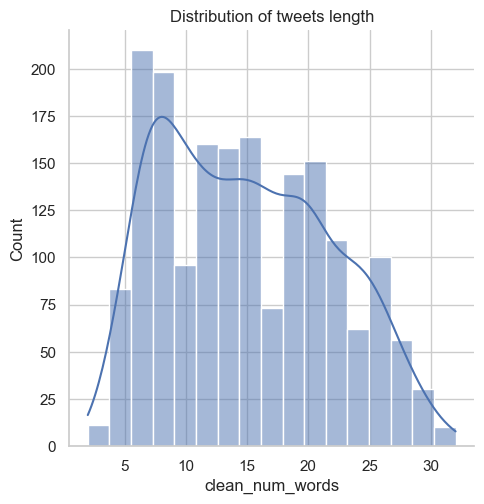

In [24]:
sns.displot(tweets['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.2. Negatif Data

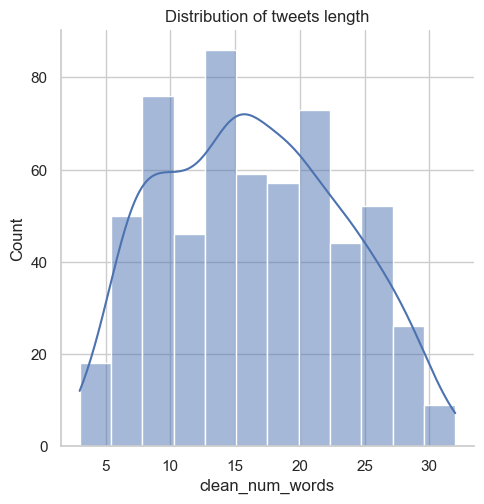

In [25]:
sns.displot(tweets_negatif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.3. Netral Data

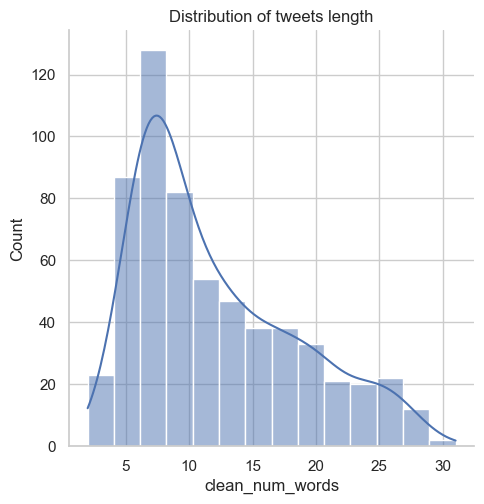

In [26]:
sns.displot(tweets_netral['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

### 4.1.4. Positif Data

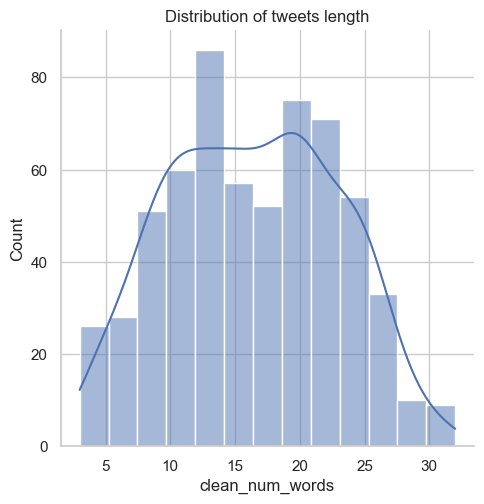

In [27]:
sns.displot(tweets_positif['clean_num_words'], kde=True)
plt.title('Distribution of tweets length')
plt.show()

## 4.2. WordCloud

In [28]:
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore")

In [29]:
def plot_word_cloud(data):
    """
    input data from Counter object
    """
    plt.figure(figsize=(12,10))
#     wc = WordCloud(background_color='white', stopword = ,max_words=50).generate(data)
    wc = WordCloud(background_color='white', max_words=200).generate_from_frequencies(data)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [30]:
def count_top_n_words(tokenized_words, n):
    word_counts = Counter(tokenized_words)
    top_n_words = word_counts.most_common(n)
    return top_n_words

In [31]:
tokenizer = RegexpTokenizer(r'\w+')

### 4.2.1. All  Sentiment

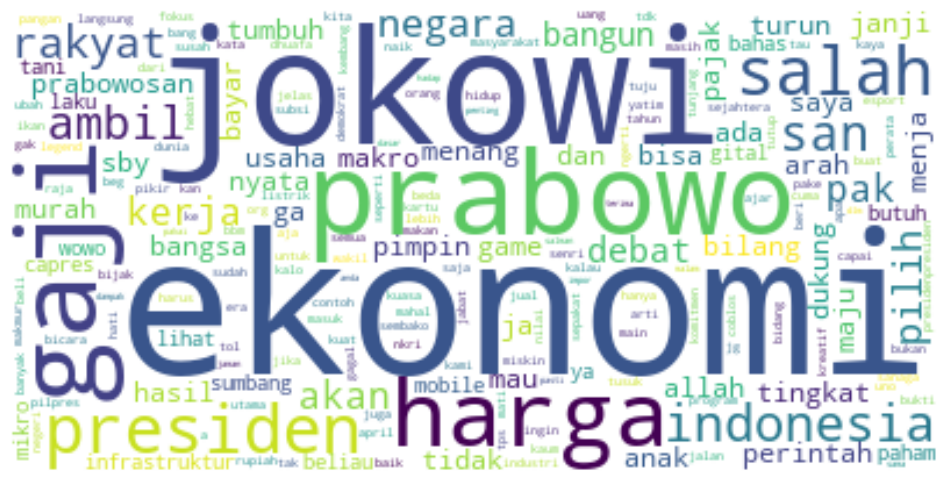

In [32]:
text_tweet = tweets['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)
plot_word_cloud(word_counts)

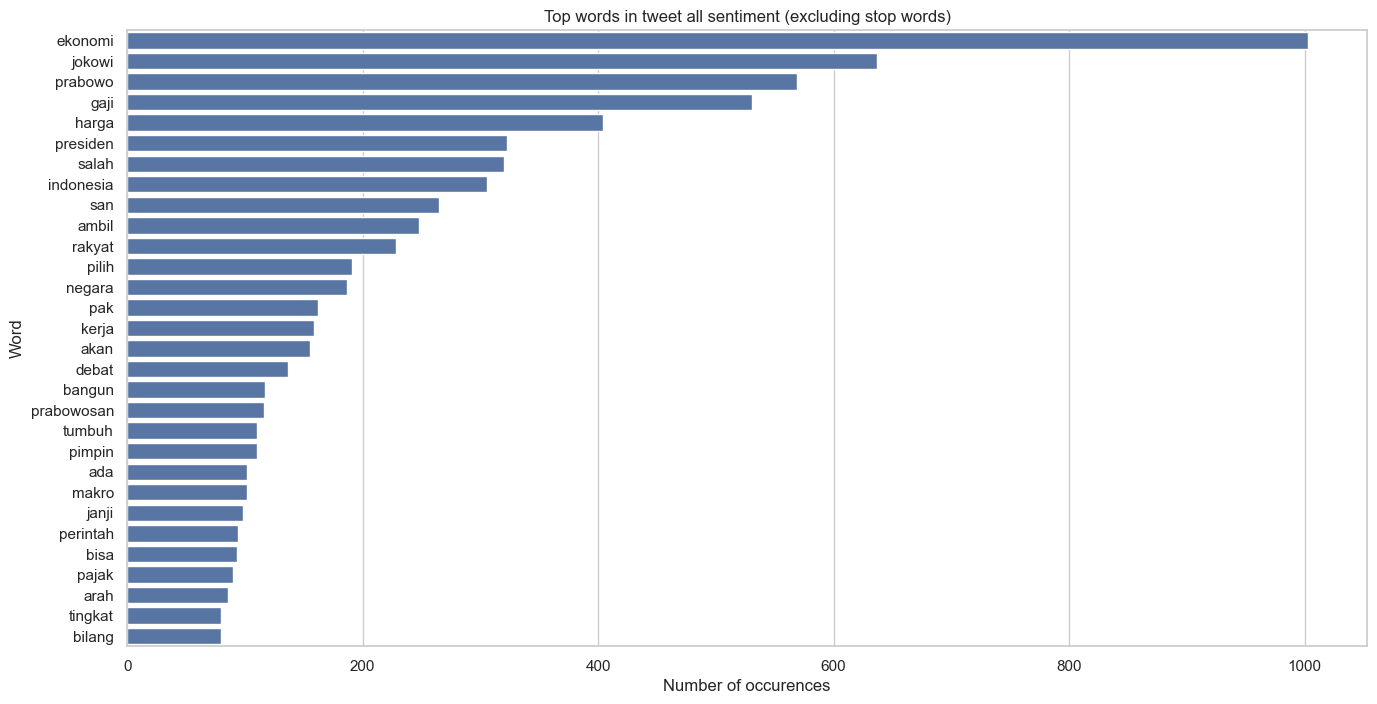

In [33]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top words in tweet all sentiment (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.2. Negatif Sentimen

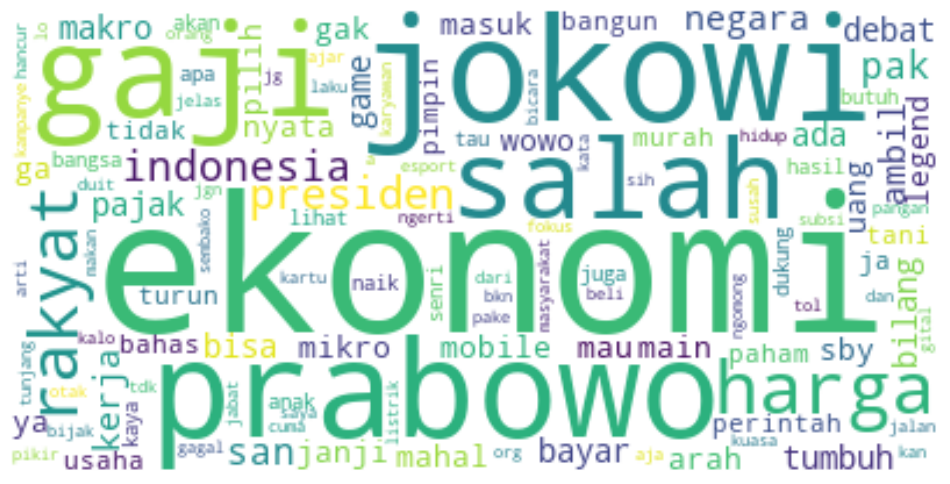

In [34]:
text_tweet = tweets_negatif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)
plot_word_cloud(word_counts)

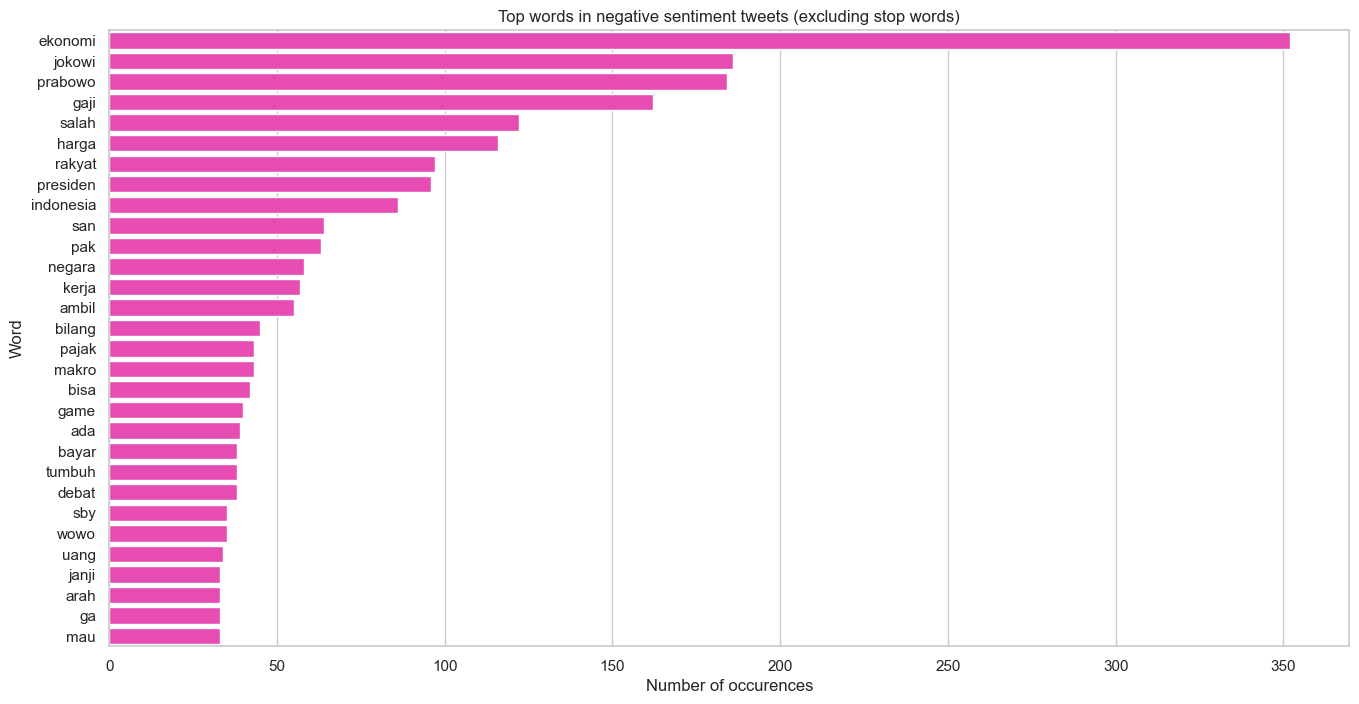

In [35]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top words in negative sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.3. Netral Sentimen

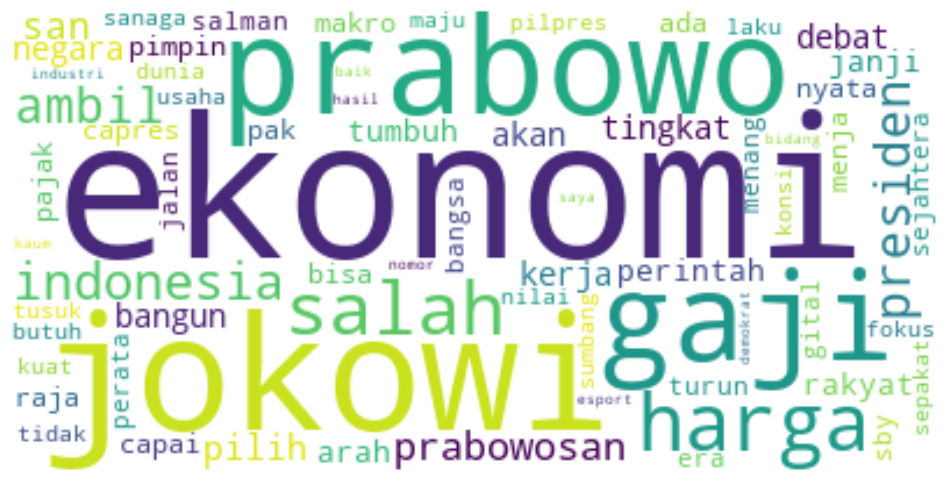

In [36]:
text_tweet = tweets_netral['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)
plot_word_cloud(word_counts)

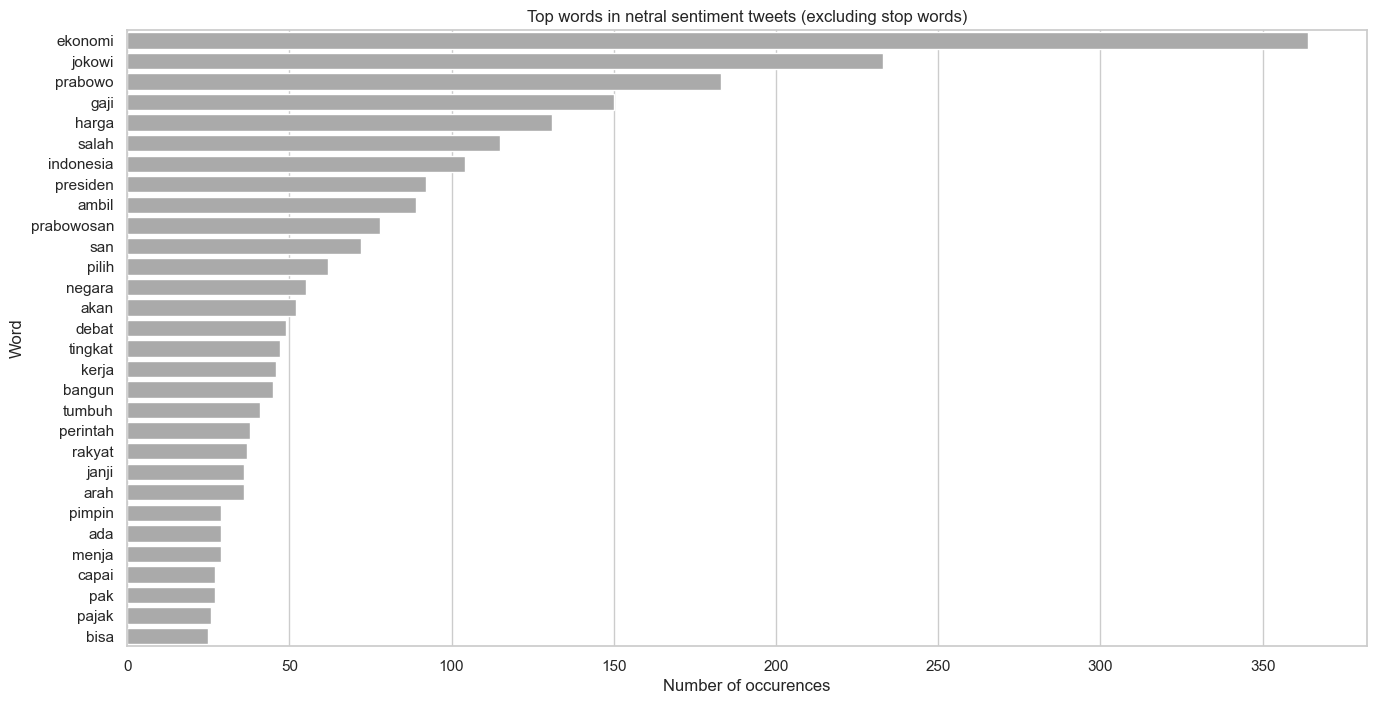

In [37]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top words in netral sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

### 4.2.4. Positif Sentimen

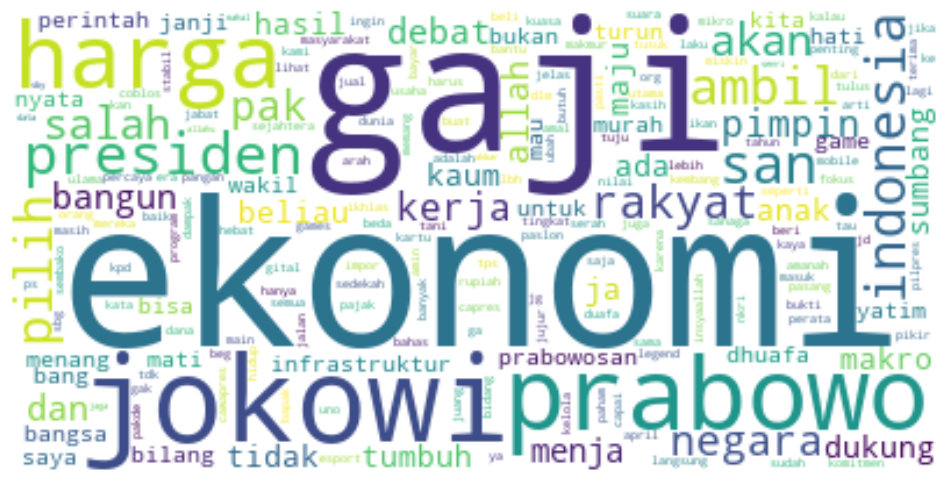

In [38]:
text_tweet = tweets_positif['cleaned_tweet'].values.tolist()
text_tweet = ' '.join(text_tweet).lower()
tokenized_text_tweet = tokenizer.tokenize(text_tweet)
word_counts = Counter(tokenized_text_tweet)
plot_word_cloud(word_counts)

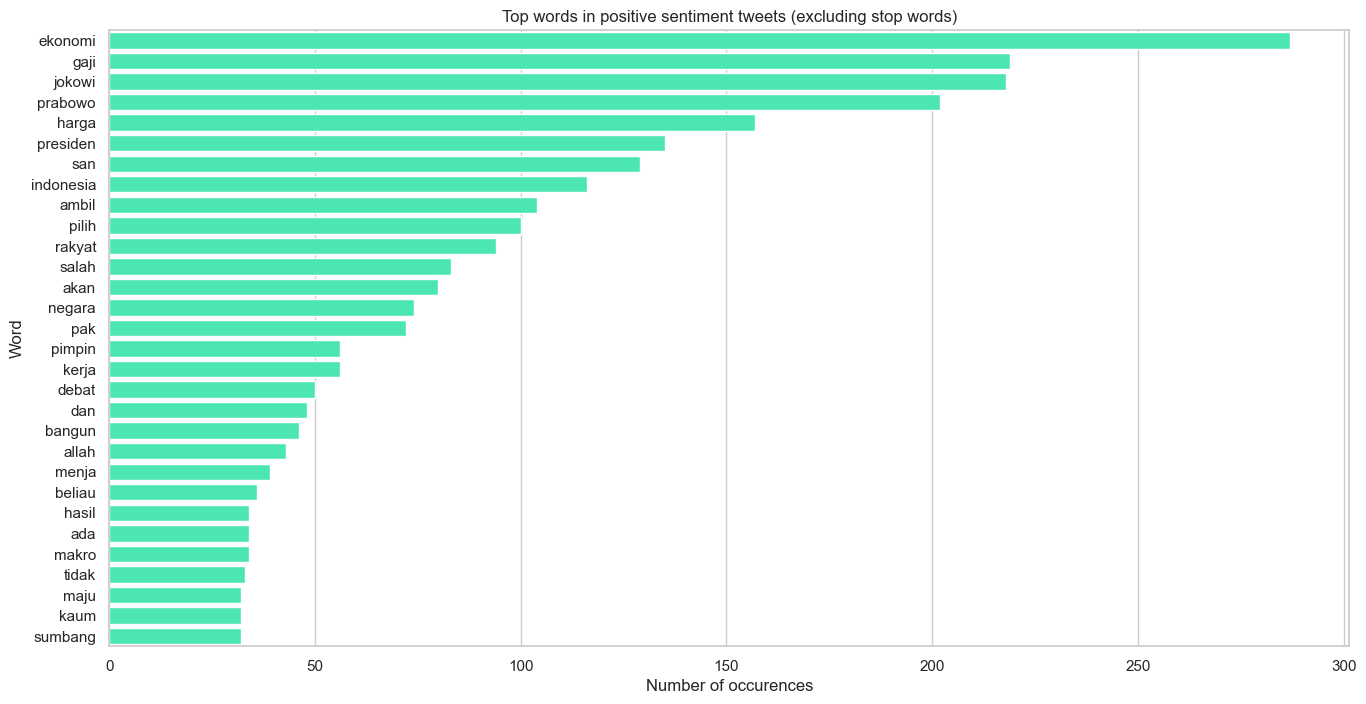

In [39]:
# Top N words
top_n_words = count_top_n_words(tokenized_text_tweet, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top words in positive sentiment tweets (excluding stop words)');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Word');
plt.show()

## 4.3. Hashtag

### 4.3.1. All  Sentiment

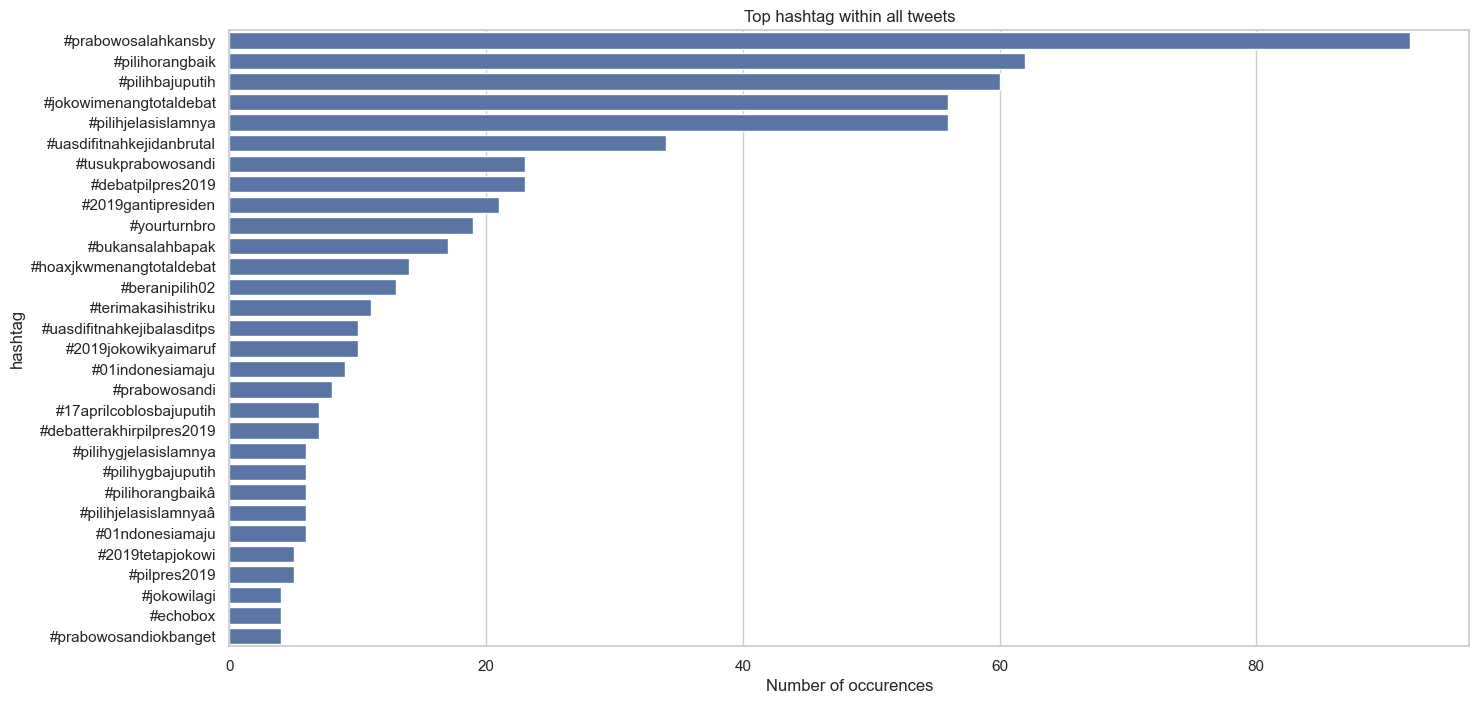

In [40]:
all_hashtags = []
_ = tweets['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top hashtag within all tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.2. Negative  Sentiment

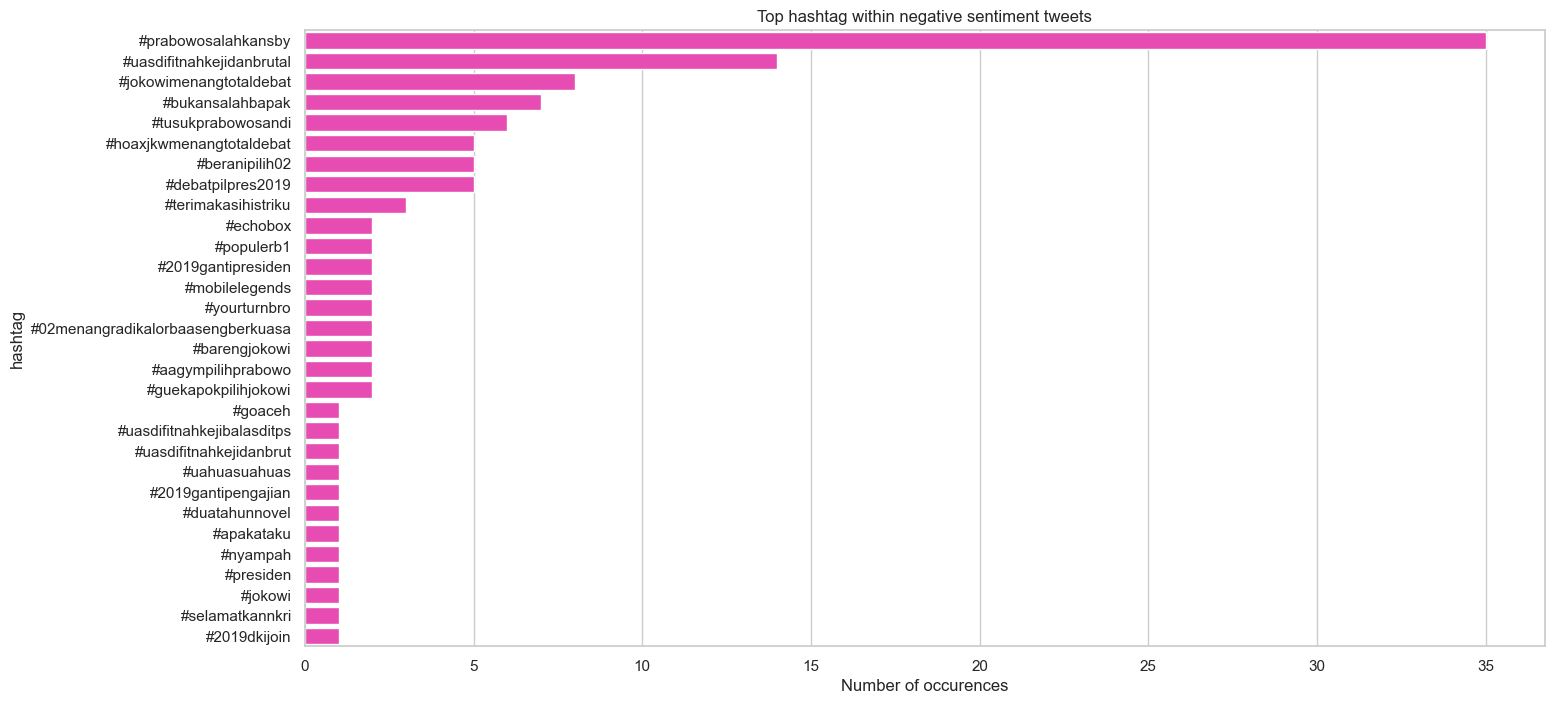

In [41]:
all_hashtags = []
_ = tweets_negatif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top hashtag within negative sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.3. Netral  Sentiment

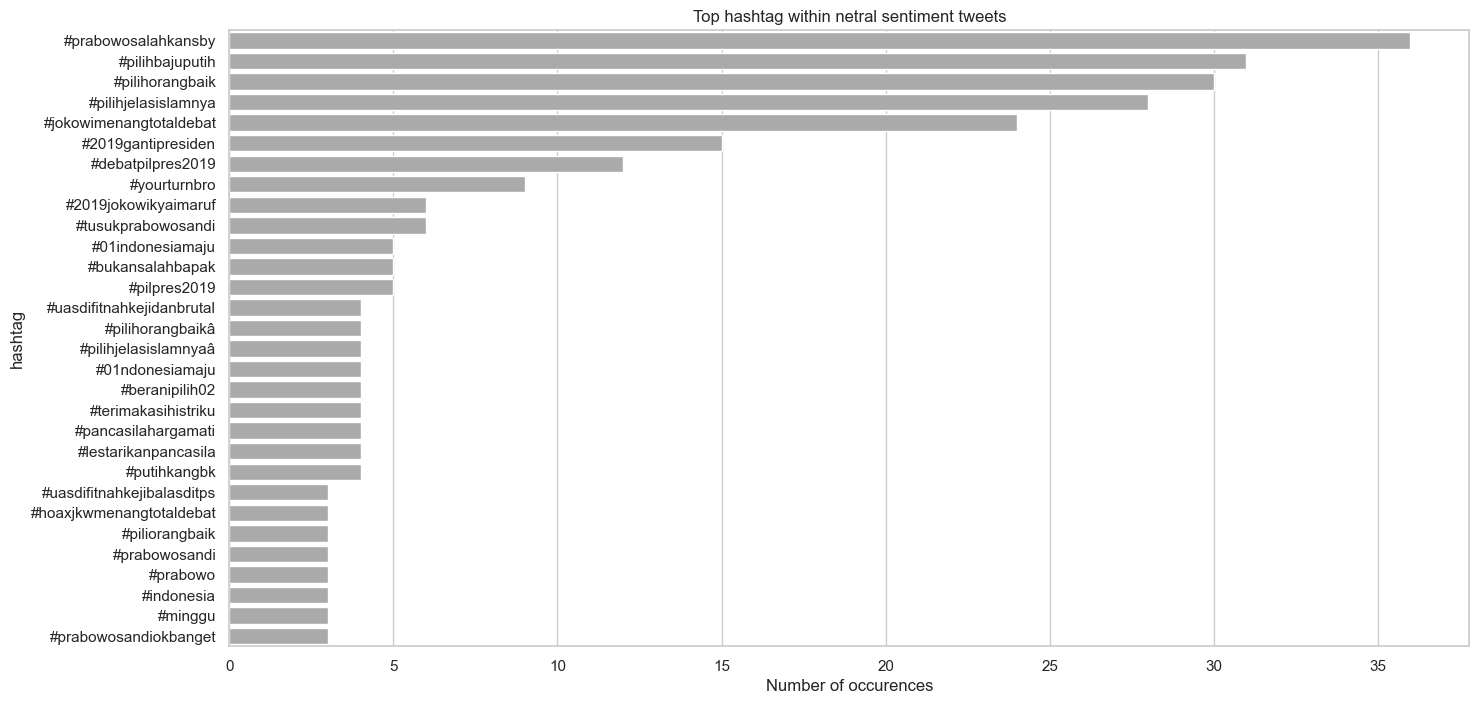

In [42]:
all_hashtags = []
_ = tweets_netral['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

### 4.3.4. Positive  Sentiment

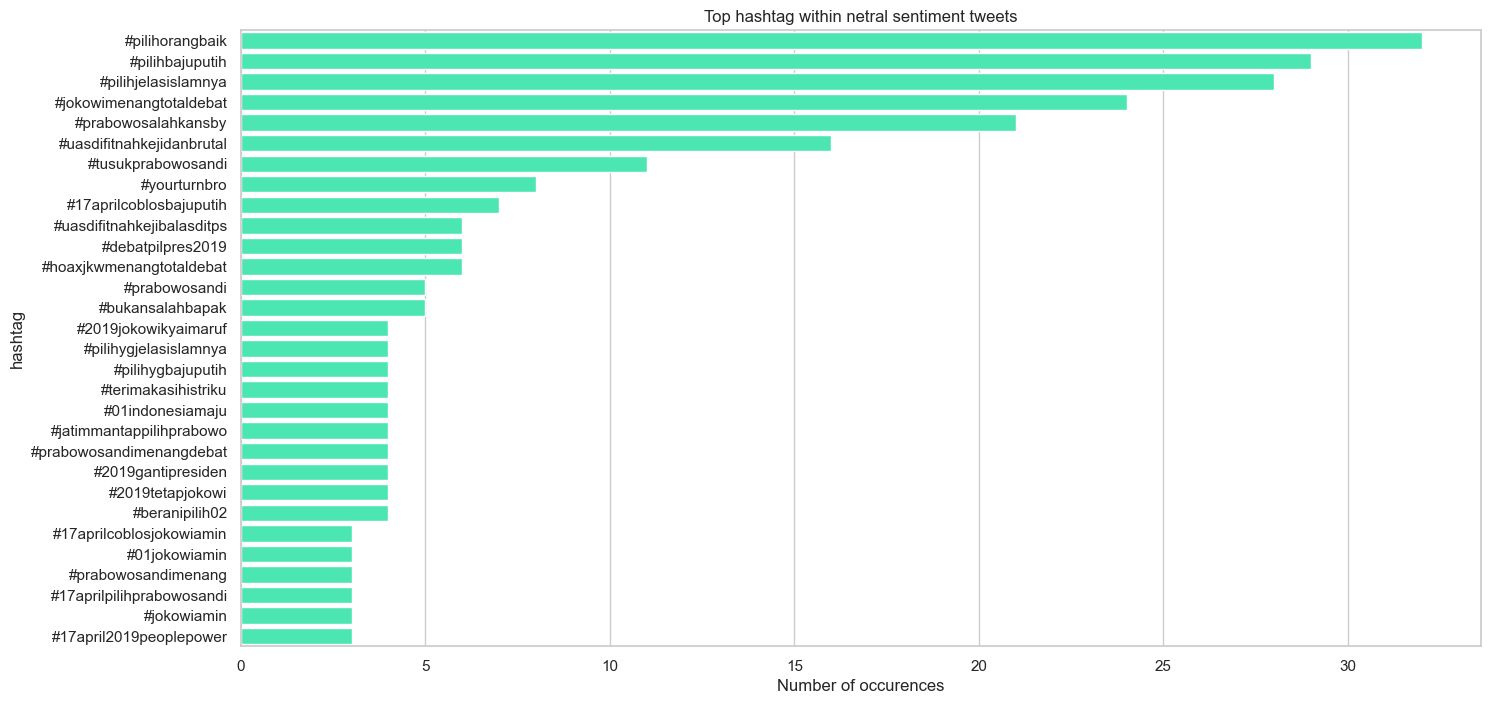

In [43]:
all_hashtags = []
_ = tweets_positif['hashtags'].apply(lambda dt: all_hashtags.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_hashtags, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top hashtag within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('hashtag');
plt.show()

# 4.4. Tagged Name

### 4.4.1. All  Sentiment

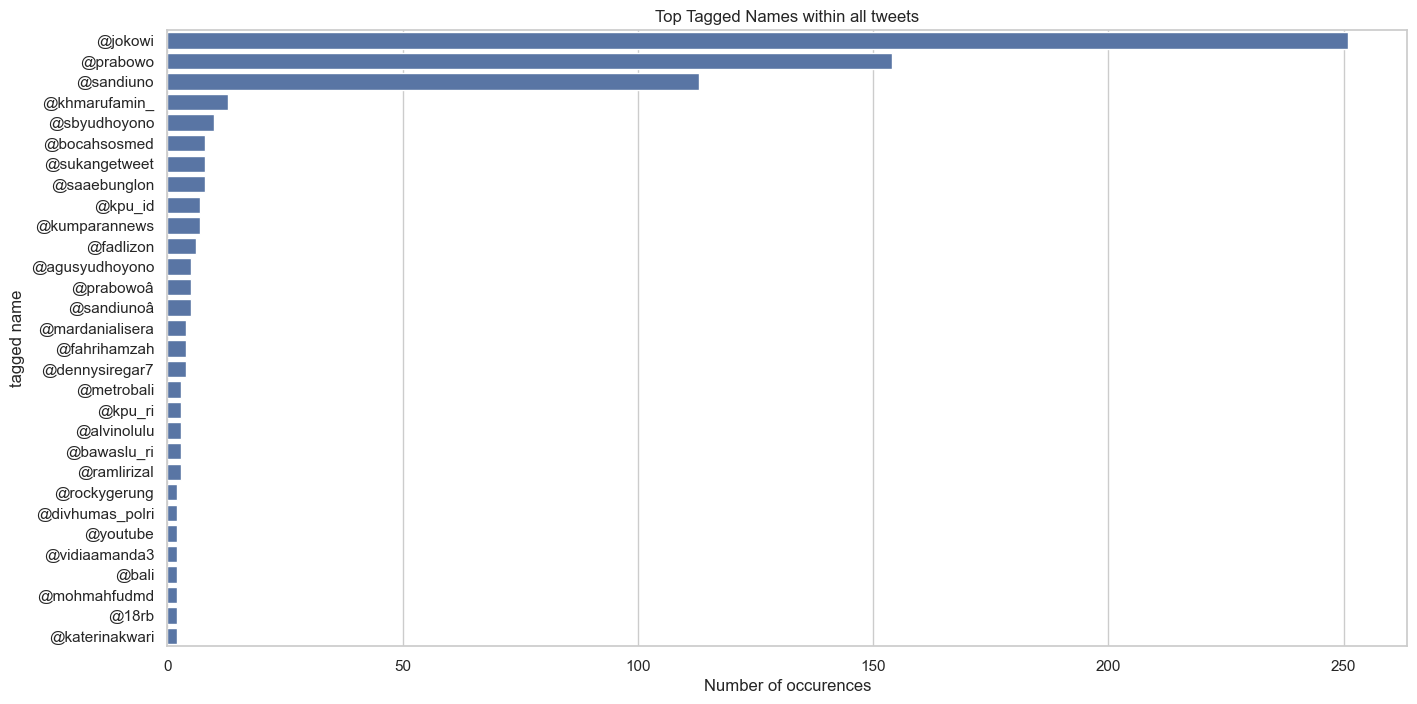

In [44]:
all_tagged = []
_ = tweets['tagged_name'].apply(lambda dt: all_tagged.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_tagged, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= 'b');
ax.set_title('Top Tagged Names within all tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('tagged name');
plt.show()

### 4.4.2. Negative  Sentiment

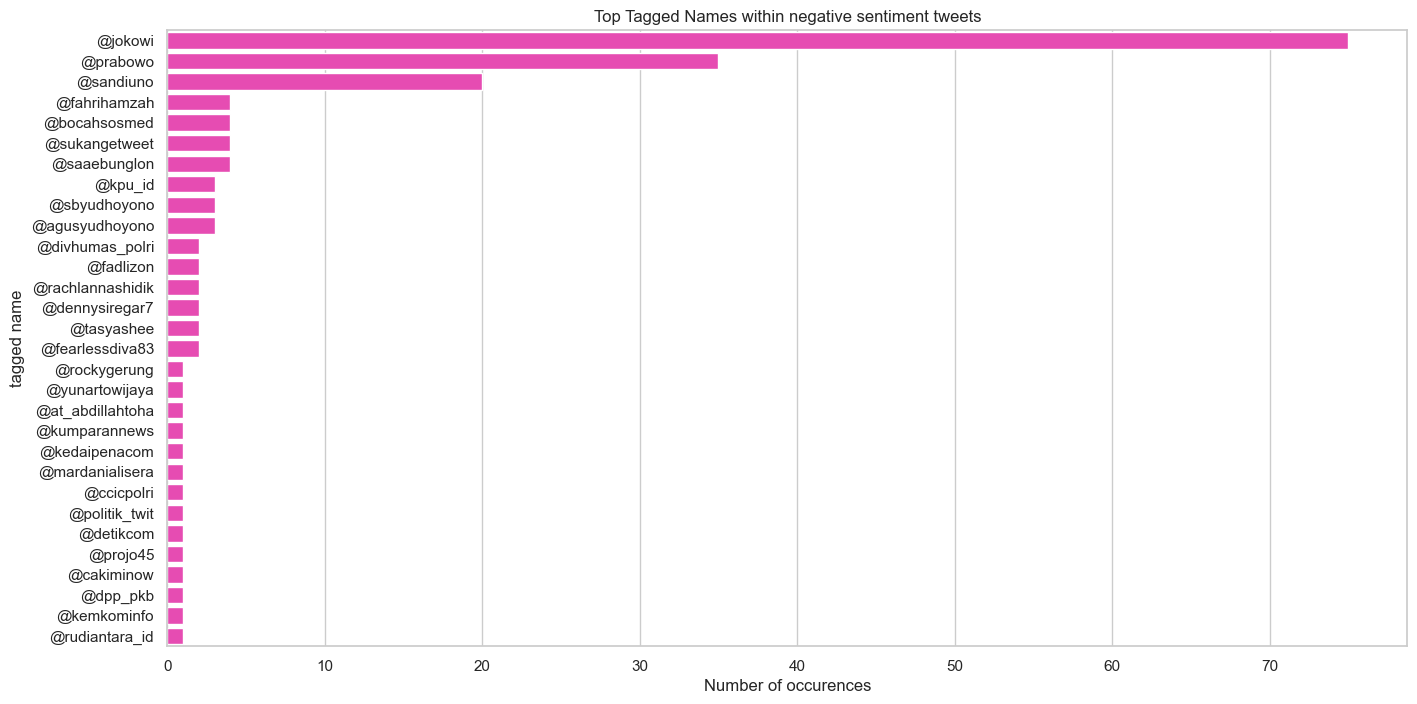

In [45]:
all_tagged = []
_ = tweets_negatif['tagged_name'].apply(lambda dt: all_tagged.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_tagged, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#FF33BB');
ax.set_title('Top Tagged Names within negative sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('tagged name');
plt.show()

### 4.4.3. Netral  Sentiment

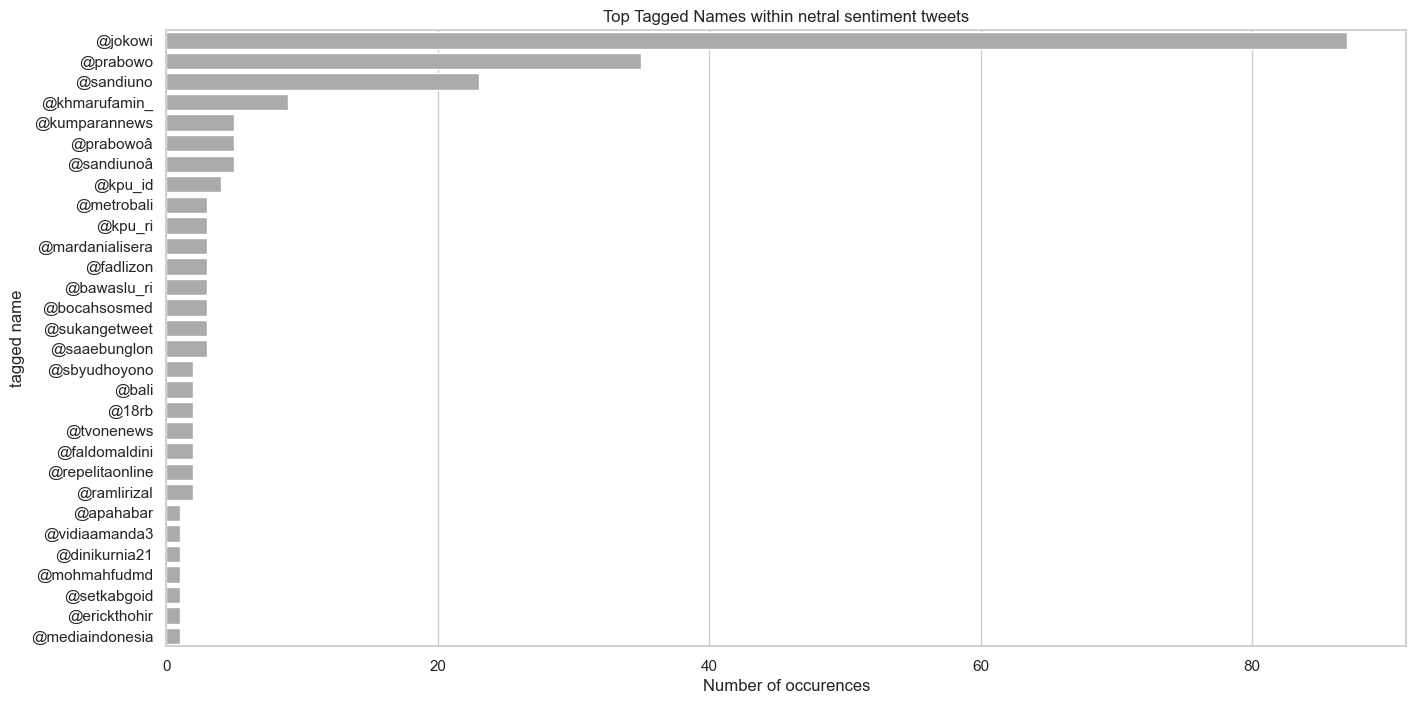

In [46]:
all_tagged = []
_ = tweets_netral['tagged_name'].apply(lambda dt: all_tagged.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_tagged, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#AAAAAA');
ax.set_title('Top Tagged Names within netral sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('tagged name');
plt.show()

### 4.4.4. Positive  Sentiment

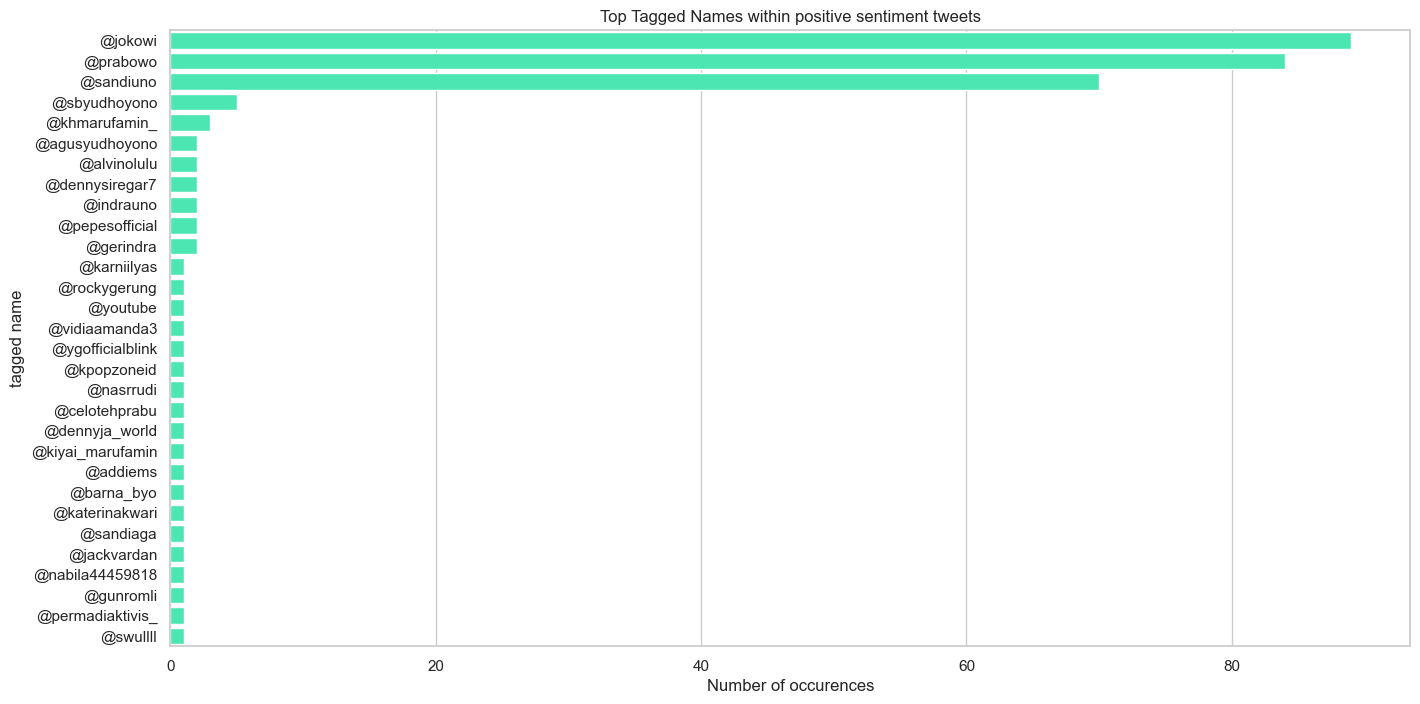

In [47]:
all_tagged = []
_ = tweets_positif['tagged_name'].apply(lambda dt: all_tagged.extend(dt))


# Top N words
top_n_words = count_top_n_words(all_tagged, 30)  # get top 15 words

df_top_words = pd.DataFrame({
    'word':[x[0] for x in top_n_words],
    'num':[x[1] for x in top_n_words] 
})

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data = df_top_words, y = 'word', x = 'num', color= '#33FFBB');
ax.set_title('Top Tagged Names within positive sentiment tweets');
ax.set_xlabel('Number of occurences');
ax.set_ylabel('tagged name');
plt.show()

# 5. Advanced Text Processing

## 5.0. Change sentiment to integer

positif    to 1

netral     to 0

negatif    to -1

In [58]:
# Replace the values in the 'sentimen' column using the specified replacements
tweets['sentimen'].replace({"negatif": -1, "netral": 0, "positif": 1}, inplace=True)

## 5.1. Split Dataset

50% for the training set

25% for the validation set

25% for the test set

In [154]:
from sklearn.model_selection import train_test_split

features = tweets[['cleaned_tweet']]
labels = tweets["sentimen"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=23)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 1270 
- Validation: 272 
- Test: 273


## 5.2. Text Vectorization (TFIDF)

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [156]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit = tfidf_vect.fit(X_train['cleaned_tweet'])
X_train = vectorize(X_train['cleaned_tweet'], tfidf_vect_fit)

In [157]:
X_train

,aaamiin,aamiin,aamiinn,aaminnnn,aammiin,aba,abah,abai,aban,abang,...,yuk,yunus,yurop,yusuf,zaenal,zakat,zaman,zero,ziarah,zon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Build Random Forest Model

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# create baseliner RF model
base_rf = RandomForestClassifier(random_state = 23)
scores = cross_val_score(base_rf, X_train, y_train.values.ravel(), cv=5)

In [159]:
print(scores)
print(scores.mean())

[0.6023622  0.57480315 0.55511811 0.60629921 0.56299213]
0.5803149606299213


### Learning Curve (base model RF)

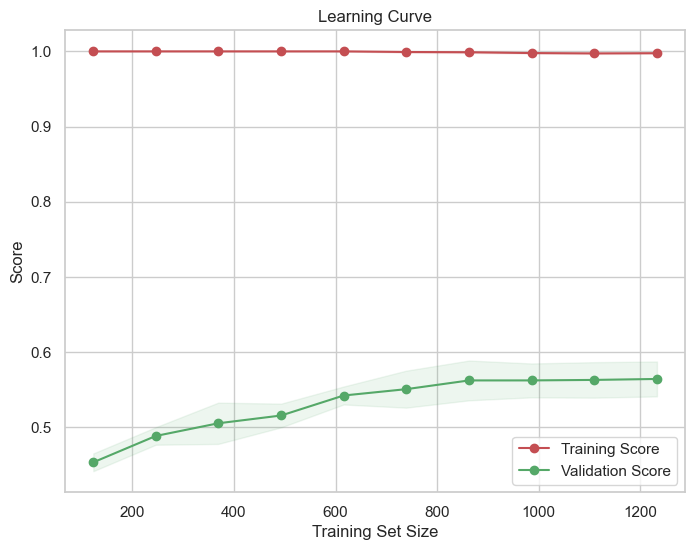

In [190]:
from sklearn.model_selection import learning_curve
sns.set(style='whitegrid')

# initiate RF model (with best params)
# best_rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2, max_features= 'log2')
base_rf = RandomForestClassifier(random_state = 23)
# Define the train_sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(base_rf, X, Y, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [179]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=23)
parameters = {
    'n_estimators': [50,100,300,500],
    'max_depth': [2,5,10,20],
    'min_samples_split': [2, 5, 10],  # kalo lama bgt dicomment saja
#     'min_samples_leaf': [1, 2, 4]     # kalo lama bgt dicomment saja
    "max_features": ['sqrt', 'log2', None]
}

cv = GridSearchCV(rf, parameters, cv = 5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 300, 500]})

In [161]:
# mean_test_score = []
# std_test_score = []
# max_depth = []
# min_samples_split = []
# n_estimators = []


# for idx in range(len(cv.cv_results_['std_test_score'])):
#     max_depth.append(cv.cv_results_['params'][idx]['max_depth'])
#     min_samples_split.append(cv.cv_results_['params'][idx]['min_samples_split'])
#     n_estimators.append(cv.cv_results_['params'][idx]['n_estimators'])
#     mean_test_score.append(cv.cv_results_['mean_test_score'][idx])
#     std_test_score.append(cv.cv_results_['std_test_score'][idx])

In [180]:
cv.cv_results_

{'mean_fit_time': array([ 0.14108057,  0.24219151,  0.57172599,  0.96056547,  0.13328934,
         0.21711321,  0.6069098 ,  1.04951887,  0.1555429 ,  0.22997723,
         0.68238454,  0.97655067,  0.08916183,  0.16051497,  0.39327993,
         0.59442692,  0.10856333,  0.15818148,  0.37948284,  0.65132461,
         0.10600724,  0.15419717,  0.38250604,  0.60430098,  1.68629971,
         3.43806028, 10.39674215, 16.80247154,  1.78776383,  3.72980347,
        10.12720242, 17.547365  ,  1.75320077,  3.56030555, 10.15555205,
        17.13705316,  0.18874421,  0.37005429,  0.96504273,  1.59453931,
         0.18753419,  0.3390183 ,  0.98086996,  1.61918116,  0.18767142,
         0.4364481 ,  0.98586135,  1.6026053 ,  0.11377811,  0.17732081,
         0.4633512 ,  0.77667899,  0.11280279,  0.18657293,  0.44727464,
         0.76121383,  0.10602608,  0.17443075,  0.47743716,  0.72022328,
         2.90448565,  5.82765064, 16.83295126, 28.65293751,  2.86905246,
         5.68974385, 18.38649044, 

In [182]:
df_tuning_results = pd.DataFrame(cv.cv_results_).sort_values('rank_test_score')
df_tuning_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
123,1.467605,0.034835,0.068056,0.011954,20,log2,2,500,"{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}",0.629921,0.578740,0.519685,0.633858,0.602362,0.592913,0.041710,1
91,0.978073,0.031709,0.057910,0.005317,10,log2,5,500,"{'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}",0.614173,0.590551,0.527559,0.606299,0.598425,0.587402,0.030940,2
111,3.439151,0.068438,0.074109,0.012448,20,sqrt,2,500,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}",0.594488,0.590551,0.562992,0.606299,0.578740,0.586614,0.014731,3
110,2.135704,0.032902,0.050222,0.005873,20,sqrt,2,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}",0.590551,0.590551,0.555118,0.610236,0.582677,0.585827,0.017852,4
131,1.352049,0.036674,0.131749,0.143115,20,log2,10,500,"{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 500}",0.614173,0.578740,0.523622,0.629921,0.582677,0.585827,0.036544,4
122,0.878209,0.029421,0.048219,0.006791,20,log2,2,300,"{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 300}",0.614173,0.555118,0.535433,0.614173,0.606299,0.585039,0.033183,6
75,2.407710,0.040453,0.067494,0.008866,10,sqrt,2,500,"{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}",0.566929,0.598425,0.555118,0.610236,0.590551,0.584252,0.020320,7
119,3.308513,0.045673,0.066451,0.008477,20,sqrt,10,500,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}",0.590551,0.578740,0.547244,0.614173,0.590551,0.584252,0.021793,7
127,1.395744,0.066769,0.068030,0.009014,20,log2,5,500,"{'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}",0.606299,0.590551,0.531496,0.602362,0.586614,0.583465,0.026979,9
95,0.974670,0.030279,0.064305,0.006619,10,log2,10,500,"{'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 500}",0.594488,0.586614,0.539370,0.606299,0.586614,0.582677,0.022821,10


In [183]:
# pd.DataFrame({
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'n_estimators':n_estimators,
#     'mean_test_score':mean_test_score,
#     'std_test_score':std_test_score
# })

In [184]:
cv.best_params_

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [186]:
# implement vectorization to validation set
X_val = vectorize(X_val['cleaned_tweet'], tfidf_vect_fit)

# evaluate the model using test set
X_test = vectorize(X_test['cleaned_tweet'],tfidf_vect_fit)

### Learning Curve (after tuning)

In [187]:
X = pd.concat([X_train, X_val])
Y = pd.concat([y_train, y_val])

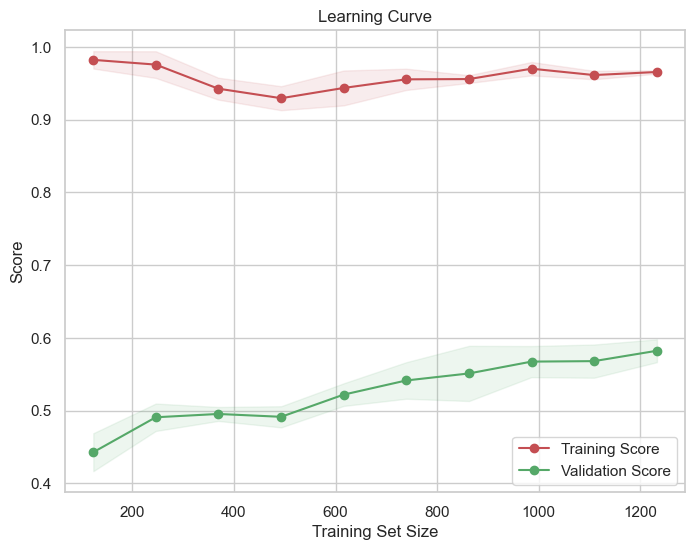

In [188]:
from sklearn.model_selection import learning_curve
sns.set(style='whitegrid')

# initiate RF model (with best params)
best_rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2, max_features= 'log2')

# Define the train_sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(best_rf, X, Y, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Prediction on Test Set

In [189]:
from sklearn.metrics import classification_report

# best_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)
best_rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2, max_features= 'log2')
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['negatif','netral','positif']))

              precision    recall  f1-score   support

     negatif       0.53      0.62      0.57        78
      netral       0.58      0.72      0.64        92
     positif       0.71      0.47      0.56       103

    accuracy                           0.59       273
   macro avg       0.60      0.60      0.59       273
weighted avg       0.61      0.59      0.59       273



In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# create baseliner RF model
# base_rf = RandomForestClassifier(random_state = 23)
scores = cross_val_score(best_rf, X_train, y_train.values.ravel(), cv=5)

print(scores)
print(scores.mean())

[0.59055118 0.57086614 0.54330709 0.58267717 0.57874016]
0.5732283464566928


# Next Improvements
- try change the word vectorization using GloVe or Word2Vec
- handle slang word
- add topic modeling for better EDA
- set min df (minimial kata-kata di tweet yang akan dipakai)
- perbaiki cara membawakan presentasi
   - perlu lebih detail jelaskan arsitektur per modelnya